# 1. FBS EDA

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

## 1) data load & column 추출

In [41]:
# x변수로 sex, age, ht, wt, waist, smoking, alcohol / y는 sbp

df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [42]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','식전혈당(공복혈당)']]

df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','fbs']

## 2) 결측값 (null) 제거

In [43]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999062 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999062 non-null  int64  
 1   age      999062 non-null  int64  
 2   ht       999062 non-null  int64  
 3   wt       999062 non-null  int64  
 4   waist    999062 non-null  float64
 5   smoking  999062 non-null  float64
 6   alcohol  999062 non-null  object 
 7   fbs      999062 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


## 3) bmi(체질량지수), absi(체형지수) 추가

In [44]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)
df = df.round(decimals=2)


df['absi'] = (df['waist']*0.393701) /((df['bmi']**0.6666) * ((df['ht']/100)**0.5))
df = df.round(decimals = 2)

df.head()

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi
0,1,8,170,75,90.0,1.0,Y,99.0,25.95,3.10
1,1,7,180,80,89.0,3.0,N,106.0,24.69,3.08
2,1,9,165,75,91.0,1.0,N,98.0,27.55,3.06
3,1,11,175,80,91.0,1.0,N,95.0,26.12,3.08
4,1,11,165,60,80.0,1.0,N,101.0,22.04,3.12


## 4) float형 변환

In [45]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

In [46]:
df.head()

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi
0,1,8,170,75,90.0,1.0,1.0,99.0,25.95,3.10
1,1,7,180,80,89.0,3.0,0.0,106.0,24.69,3.08
2,1,9,165,75,91.0,1.0,0.0,98.0,27.55,3.06
3,1,11,175,80,91.0,1.0,0.0,95.0,26.12,3.08
4,1,11,165,60,80.0,1.0,0.0,101.0,22.04,3.12


In [47]:
df.loc[(df['fbs']>600.0)|(df['fbs']<37.0)][(df['bmi']<30)]

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi
80477,1,12,165,55,83.0,3.0,0.0,685.0,20.20,3.43
87731,1,14,170,85,98.7,2.0,1.0,629.0,29.41,3.13
117972,1,11,170,65,86.0,3.0,1.0,616.0,22.49,3.26
162578,1,12,160,65,89.0,3.0,1.0,663.0,25.39,3.21
225292,1,15,160,55,77.0,2.0,0.0,769.0,21.48,3.10
264190,1,11,170,60,77.0,2.0,1.0,32.0,20.76,3.08
419769,2,13,150,45,71.0,1.0,1.0,617.0,20.00,3.10
424684,1,11,180,85,100.0,3.0,1.0,30.0,26.23,3.32
452616,2,10,155,55,80.7,1.0,1.0,36.0,22.89,3.17
481284,1,17,155,65,97.0,1.0,0.0,25.0,27.06,3.40


## 5) 이상치 탐지 - 연속형 변수

### bmi

In [48]:
df.bmi.describe()

count    999062.000000
mean         23.914353
std           3.516952
min          12.490000
25%          21.480000
50%          23.880000
75%          25.950000
max          45.710000
Name: bmi, dtype: float64

lower :  8.070000000000004
upper :  39.36


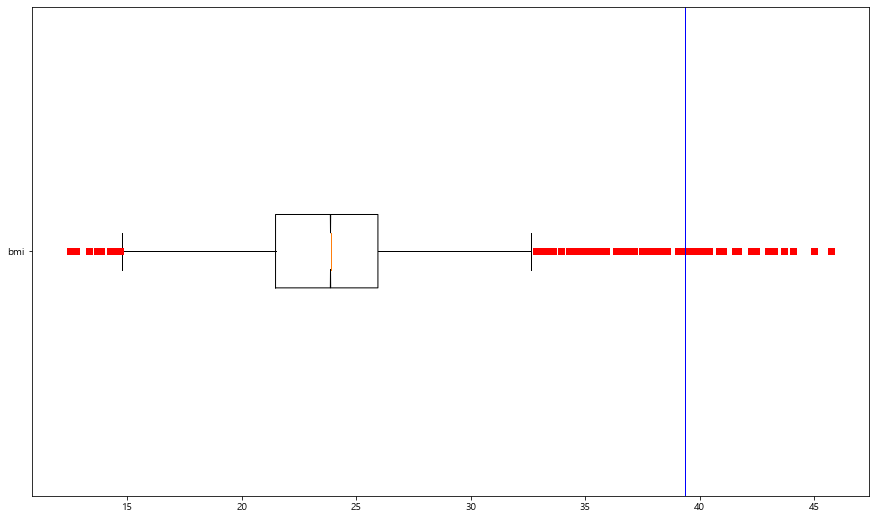

In [10]:
q25, q75 = np.quantile(df['bmi'], 0.25), np.quantile(df['bmi'], 0.75)
q50 = np.quantile(df['bmi'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['bmi'], 
            notch = 1, sym = 'rs', vert = 0)
plt.xticks(range(10, 50,5))
plt.yticks([1],['bmi'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.show()

### waist

In [11]:
df.waist.describe()

count    999062.000000
mean         81.231525
std          11.838878
min           8.000000
25%          74.100000
50%          81.000000
75%          87.800000
max         999.000000
Name: waist, dtype: float64

lower :  32.999999999999986
upper :  128.9


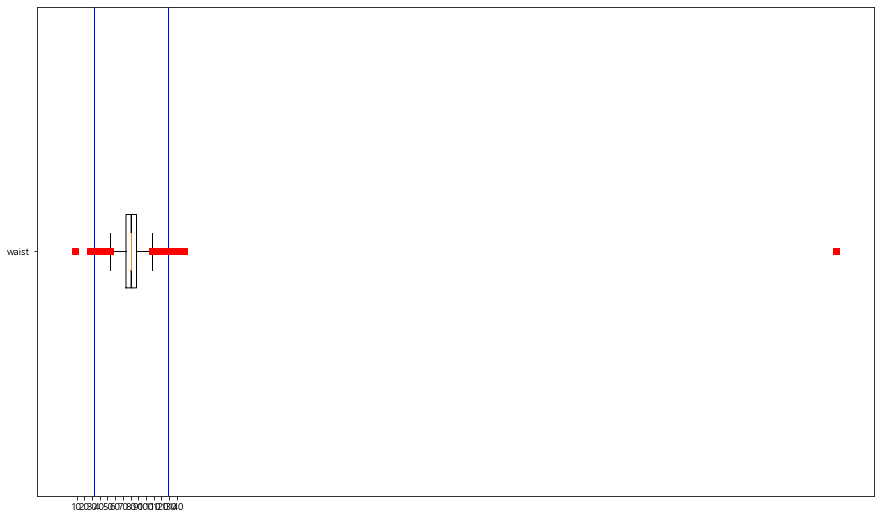

In [12]:
q25, q75 = np.quantile(df['waist'], 0.25), np.quantile(df['waist'], 0.75)
q50 = np.quantile(df['waist'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['waist'], 
            notch = 1, sym = 'rs', vert = 0)
plt.xticks(range(10,150,10))
plt.yticks([1],['waist'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.vlines(x = lower, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )

plt.show()

### fbs

In [13]:
df.fbs.describe()

count    999062.000000
mean        100.457737
std          24.255089
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         852.000000
Name: fbs, dtype: float64

lower :  37.0
upper :  156.0


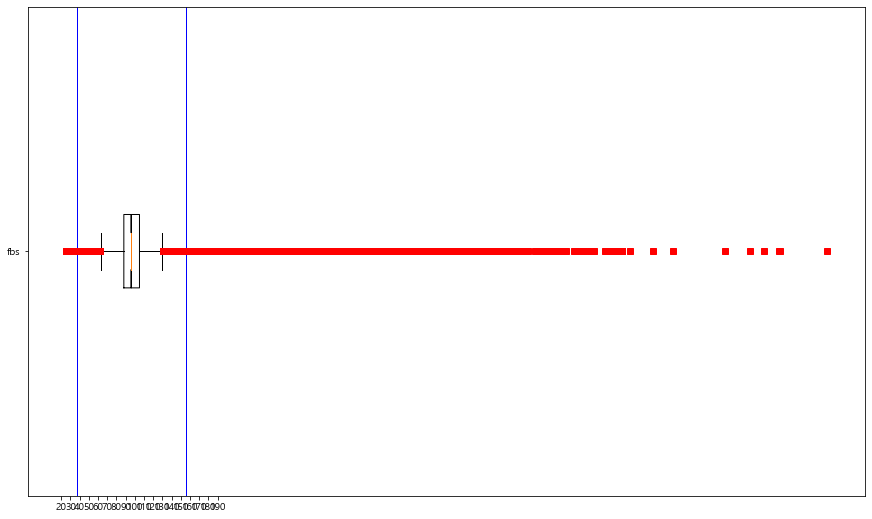

In [14]:
q25, q75 = np.quantile(df['fbs'], 0.25), np.quantile(df['fbs'], 0.75)
q50 = np.quantile(df['fbs'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['fbs'], 
            notch = 1, sym = 'rs', vert = 0)
plt.xticks(range(20,200,10))
plt.yticks([1],['fbs'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.vlines(x = lower, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.show()

### absi

In [15]:
df.absi.describe()

count    999062.000000
mean          3.034875
std           0.331350
min           0.360000
25%           2.900000
50%           3.030000
75%           3.160000
max          47.190000
Name: absi, dtype: float64

lower :  2.119999999999999
upper :  3.940000000000001


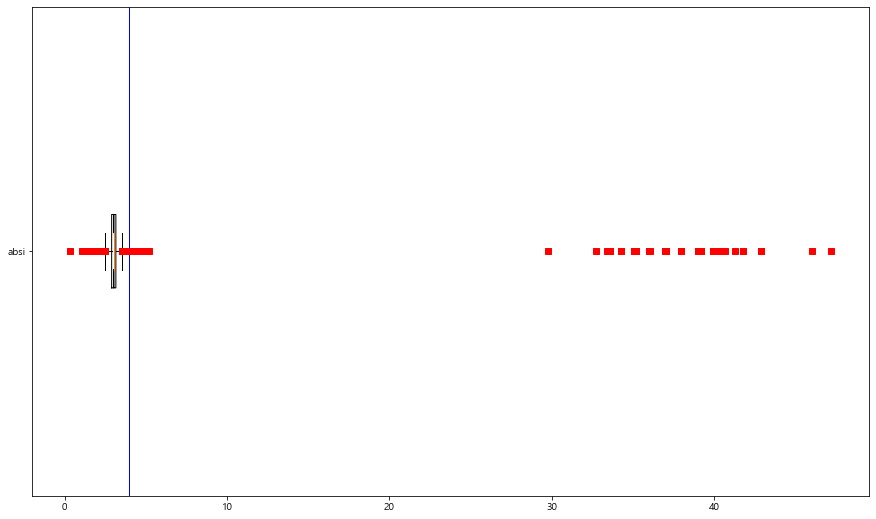

In [16]:
q25, q75 = np.quantile(df['absi'], 0.25), np.quantile(df['absi'], 0.75)
q50 = np.quantile(df['absi'], 0.5)

IQR = q75 - q25

lower = q25 - IQR*3
upper = q75 + IQR*3

print('lower : ', lower)
print('upper : ', upper)

plt.figure(figsize = (15,9))
plt.boxplot(df['absi'], 
            notch = 1, sym = 'rs', vert = 0)

plt.yticks([1],['absi'])
plt.vlines(x = upper, ymin = 0.5, ymax = 1.5, color = 'b', linewidth = 1 )
plt.show()

## df : 이상치 제거 / df_o : 이상치 제거하지 않은 원본 df

In [49]:
df_o = df.copy()

# bmi
#df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index, inplace = True)

# waist
df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55)].index, inplace = True)

# absi
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)

# fbs
#df.drop(df.loc[(df['fbs']>156.0)|(df['fbs']<37.0)].index, inplace = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998122 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998122 non-null  int64  
 1   age      998122 non-null  int64  
 2   ht       998122 non-null  int64  
 3   wt       998122 non-null  int64  
 4   waist    998122 non-null  float64
 5   smoking  998122 non-null  float64
 6   alcohol  998122 non-null  float64
 7   fbs      998122 non-null  float64
 8   bmi      998122 non-null  float64
 9   absi     998122 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


## 5) x변수 분포 

### 성별(SEX) - 혈당(FBS)

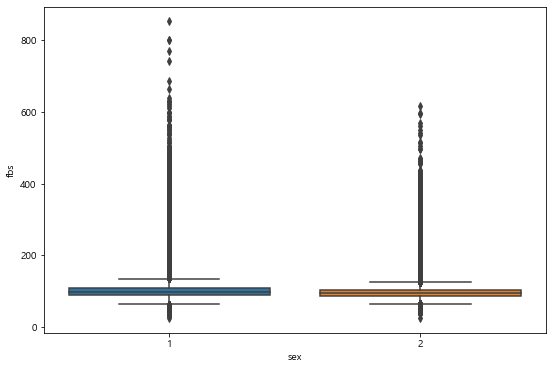

In [19]:
plt.figure(figsize = (9,6))
sns.boxplot(x = 'sex', y = 'fbs', data = df)
plt.show()

### 나이(age) - 혈당(FBS)

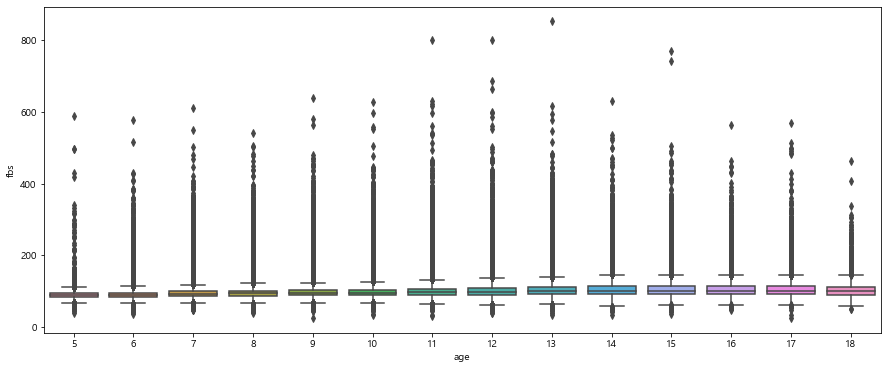

In [20]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'age', y = 'fbs', data = df)
plt.show()

### 키(ht) - 혈당(FBS)

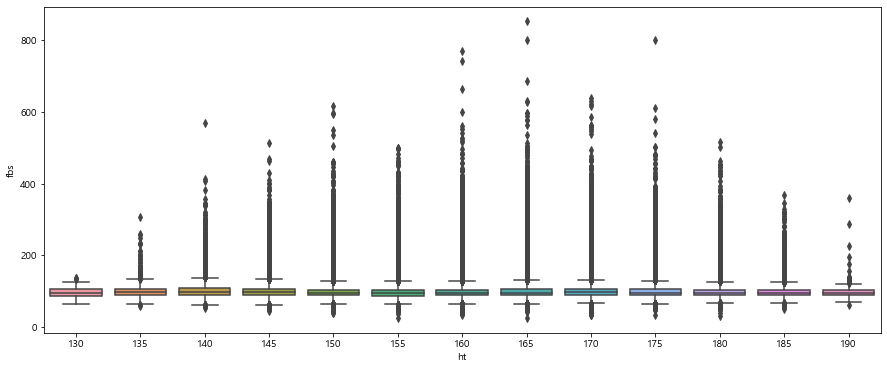

In [21]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'ht', y = 'fbs', data = df)
plt.show()

### 체중(wt) - 혈당(FBS)

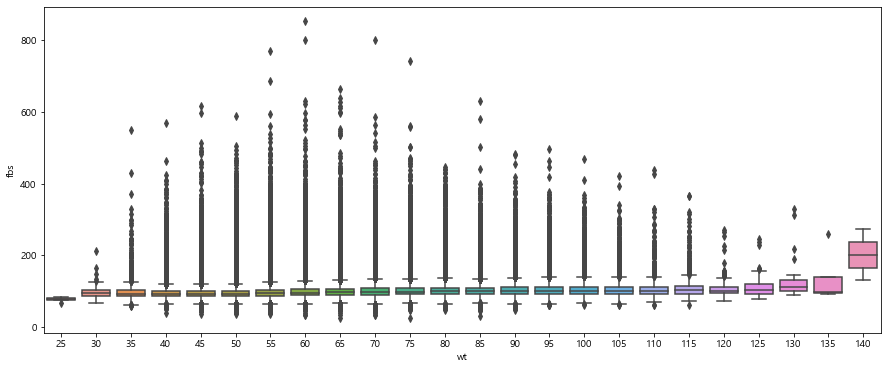

In [22]:
plt.figure(figsize = (15,6))
sns.boxplot(x = 'wt', y = 'fbs', data = df)
plt.show()

### bmi - 혈당(FBS)

- 데이터가 너무 많아서 sampling(약 10%)해서 (랜덤) scatter함수로 표현

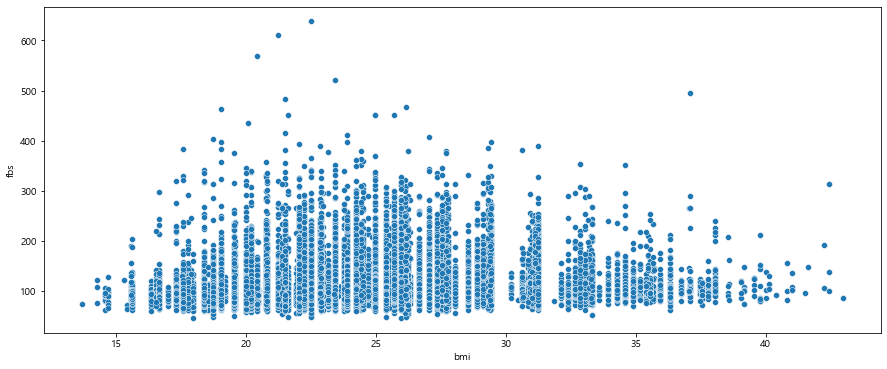

In [23]:
df_sample = df.sample(n=100000, random_state = 2045)

plt.figure(figsize = (15,6))
sns.scatterplot(df_sample.bmi, df_sample.fbs)
plt.show()

### 허리둘레(waist) - 혈당(FBS)

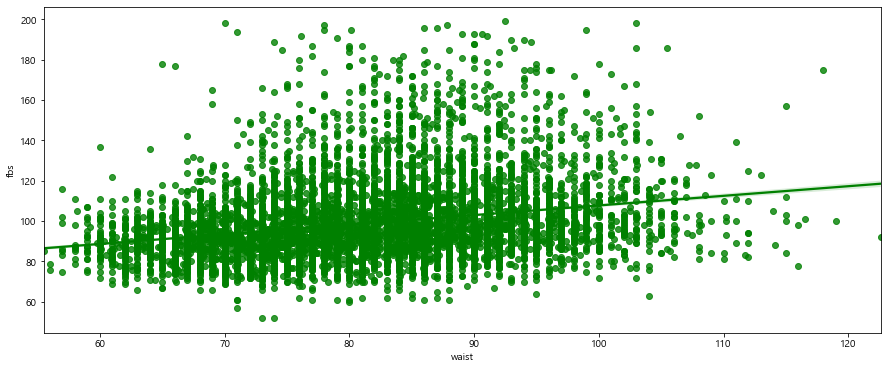

In [39]:
#df.drop(df.loc[(df['fbs']>200.0)|(df['fbs']<37.0)].index, inplace = True)
df_sample = df.sample(n=10000, random_state = 2045)

plt.figure(figsize = (15,6))
sns.regplot(df_sample.waist, df_sample.fbs, color = 'g')
plt.savefig('waist_fbs.png')
plt.show()

### 체형지수(absi) - 혈당(FBS)

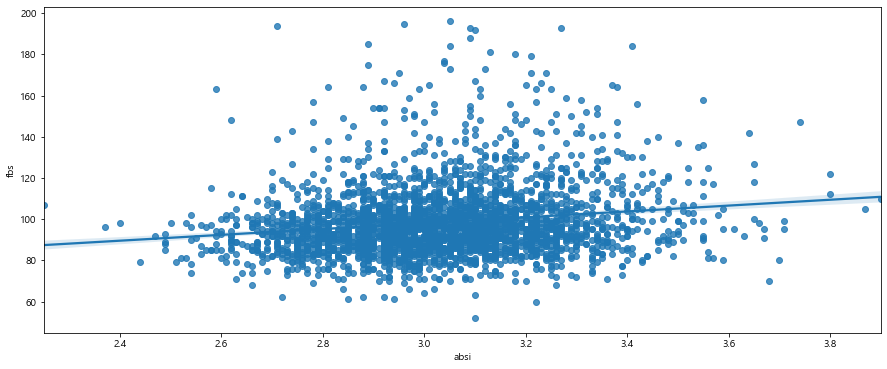

In [40]:
df_sample = df.sample(n=3000, random_state = 2045)


plt.figure(figsize = (15,6))
sns.regplot(df_sample.absi, df_sample.fbs)
plt.savefig('absi_fbs.png')
plt.show()

### 음주여부(alcohol) - 혈당(FBS)

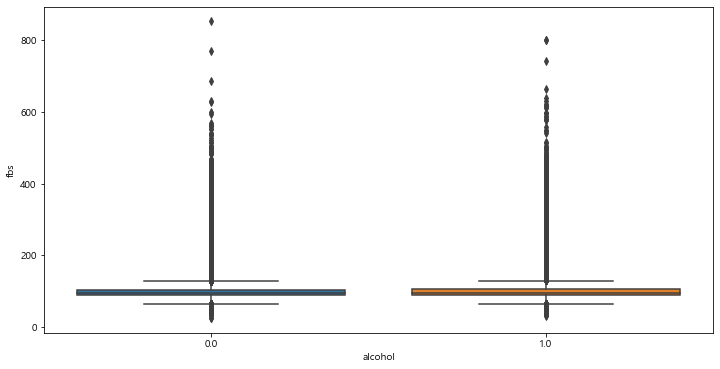

In [26]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'alcohol', y = 'fbs', data = df)
plt.show()

### 흡연상태(smoking) - 혈당(FBS)

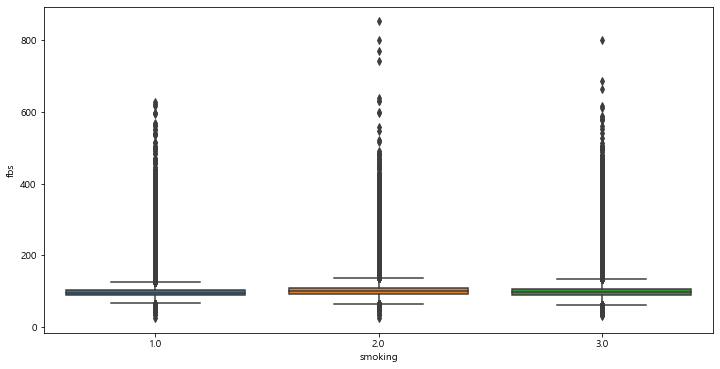

In [27]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'smoking', y = 'fbs', data = df)
plt.show()

### 혈당(FBS)

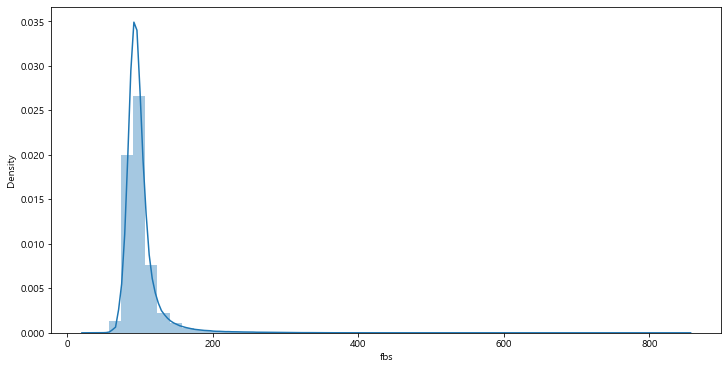

In [50]:
plt.figure(figsize = (12,6))
sns.distplot(df.fbs, hist = True, kde = True)
plt.savefig('fbs.png')
plt.show()

### 혈당의 분포가 한쪽으로 치우쳐져있는 분포 -> 로그변환

In [51]:
df['fbs_log'] = np.log1p(df['fbs'])

df.head()

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi,fbs_log
0,1,8,170,75,90.0,1.0,1.0,99.0,25.95,3.10,4.605170
1,1,7,180,80,89.0,3.0,0.0,106.0,24.69,3.08,4.672829
2,1,9,165,75,91.0,1.0,0.0,98.0,27.55,3.06,4.595120
3,1,11,175,80,91.0,1.0,0.0,95.0,26.12,3.08,4.564348
4,1,11,165,60,80.0,1.0,0.0,101.0,22.04,3.12,4.624973


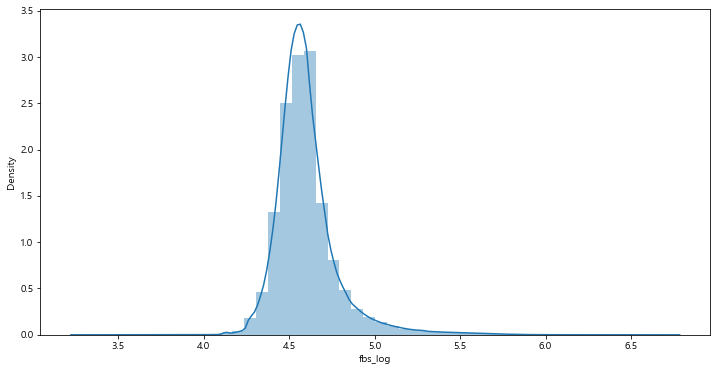

In [52]:
plt.figure(figsize = (12,6))
sns.distplot(df.fbs_log, hist = True, kde = True)
plt.savefig('fbs_log.png')
plt.show()

### x변수간 관계

In [29]:
# %%time 

# fig, axs = plt.subplots(figsize = (10,8), ncols = 3, nrows = 2, constrained_layout=True)

# sns.scatterplot(x = 'ht', y = 'wt', data = df, ax = axs[0][0])
# sns.scatterplot(x = 'ht', y = 'waist', data = df, ax = axs[0][1])
# sns.scatterplot(x = 'wt', y = 'waist', data = df, ax = axs[0][2])
# sns.scatterplot(x = 'waist', y = 'bmi', data = df, ax = axs[1][0])
# sns.scatterplot(x = 'waist', y = 'absi', data = df, ax = axs[1][1])
# sns.scatterplot(x = 'bmi', y = 'absi', data = df, ax = axs[1][2])
# plt.savefig("x_variables correlations.png")

# plt.show()


## * 변수scaling - 표준화(df_s)

In [31]:
scaler1 = StandardScaler()

x_bmi = scaler1.fit_transform(df[['bmi']])
x_waist = scaler1.fit_transform(df[['waist']])
x_absi = scaler1.fit_transform(df[['absi']])

df_s = df[['sex','age','ht','wt','smoking','alcohol','fbs']]

df_s['bmi'] = x_bmi
df_s['waist'] = x_waist
df_s['absi'] = x_absi

print(df_s.info())
df_s.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998122 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998122 non-null  int64  
 1   age      998122 non-null  int64  
 2   ht       998122 non-null  int64  
 3   wt       998122 non-null  int64  
 4   smoking  998122 non-null  float64
 5   alcohol  998122 non-null  float64
 6   fbs      998122 non-null  float64
 7   bmi      998122 non-null  float64
 8   waist    998122 non-null  float64
 9   absi     998122 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 116.0 MB
None


,sex,age,ht,wt,smoking,alcohol,fbs,bmi,waist,absi
0,1,8,170,75,1.0,1.0,99.0,0.578401,0.920789,0.339584
1,1,7,180,80,3.0,0.0,106.0,0.219741,0.816375,0.238940
2,1,9,165,75,1.0,0.0,98.0,1.033841,1.025202,0.138295
3,1,11,175,80,1.0,0.0,95.0,0.626791,1.025202,0.238940
4,1,11,165,60,1.0,0.0,101.0,-0.534581,-0.123345,0.440228


## * 변수scaling - 정규화(df_n)

In [32]:
scaler2 = MinMaxScaler()

x_bmi = scaler2.fit_transform(df[['bmi']])
x_waist = scaler2.fit_transform(df[['waist']])
x_absi = scaler2.fit_transform(df[['absi']])

df_n = df[['sex','age','smoking','ht','wt','alcohol', 'fbs']]

df_n['bmi'] = x_bmi
df_n['waist'] = x_waist
df_n['absi'] = x_absi

print(df_n.info())
df_n.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 998122 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998122 non-null  int64  
 1   age      998122 non-null  int64  
 2   smoking  998122 non-null  float64
 3   ht       998122 non-null  int64  
 4   wt       998122 non-null  int64  
 5   alcohol  998122 non-null  float64
 6   fbs      998122 non-null  float64
 7   bmi      998122 non-null  float64
 8   waist    998122 non-null  float64
 9   absi     998122 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 116.0 MB
None


,sex,age,smoking,ht,wt,alcohol,fbs,bmi,waist,absi
0,1,8,1.0,170,75,1.0,99.0,0.405178,0.479452,0.538462
1,1,7,3.0,180,80,0.0,106.0,0.367249,0.465753,0.527473
2,1,9,1.0,165,75,0.0,98.0,0.453341,0.493151,0.516484
3,1,11,1.0,175,80,0.0,95.0,0.410295,0.493151,0.527473
4,1,11,1.0,165,60,0.0,101.0,0.287477,0.342466,0.549451
